In [1]:
%reload_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
#import swifter
import networkx as nx
import japanize_matplotlib
import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
%matplotlib inline

/usr/local/lib/python3.7/site-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


In [4]:
import sys
sys.path.append('../')

import src.network_analytics as na

In [5]:
df_raw = pd.read_csv('../data/moreno_crime/out.moreno_crime_crime',
                     sep=' ', skiprows=2, header=None)
df_raw.drop(2, inplace=True, axis=1)
df_raw.columns = ['id_from', 'id_to']
#df = df_raw.sample(frac=0.1, random_state=14)
df = df_raw.copy()
df.shape

(1476, 2)

In [6]:
g1, g2 = na.gen_bipartite_network_projection(df
                                             , n1_name='id_from', n2_name='id_to'
                                            )

In [7]:
g2.number_of_nodes()

829

In [8]:
import src.node2vec as n2v
import concurrent.futures
import os

In [9]:
probs = n2v.init_probs(g2, directed=False)
G = n2v.Graph(g2, probs, p=0.5, q=0.5
              , walks_par_node=10, walk_len=80)

In [10]:
from time import time
start = time()
with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    executor.map(G.compute_probabilities_conc, list(G.graph.nodes()))  
end = time()
print("Completed in {:.2f} minutes.".format((end - start)/60))

Completed in 0.05 minutes.


In [11]:
from itertools import chain
from time import time
start = time()
with concurrent.futures.ThreadPoolExecutor(max_workers=os.cpu_count()) as executor:
    #for node in G.graph.nodes():
        #walks_map = executor.submit(G.generate_random_walks_conc, node)
    walks_map = executor.map(G.generate_node_walks_conc, list(G.graph.nodes()))

walks = list(chain.from_iterable(list(walks_map)))
end = time()
print("Completed in {:.2f} minutes.".format((end - start)/60))

Completed in 0.94 minutes.


In [12]:
len(walks[2])

80

In [14]:
model = n2v.generate_embeddings(walks, dimensions=128, window=5, workers=1
                                , p=0.5, q=0.5, output_file='./n2v.model')


Saved model to :  ./n2v.model
Time elapsed for Generating embeddings ----> 0:00:26.195887

---------------------------------------



In [15]:
tokens = [model[word] for word in model.wv.vocab]
labels = [word for word in model.wv.vocab]


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


In [16]:
len(tokens)

829

In [19]:
import umap

emb = umap.UMAP().fit_transform(tokens)


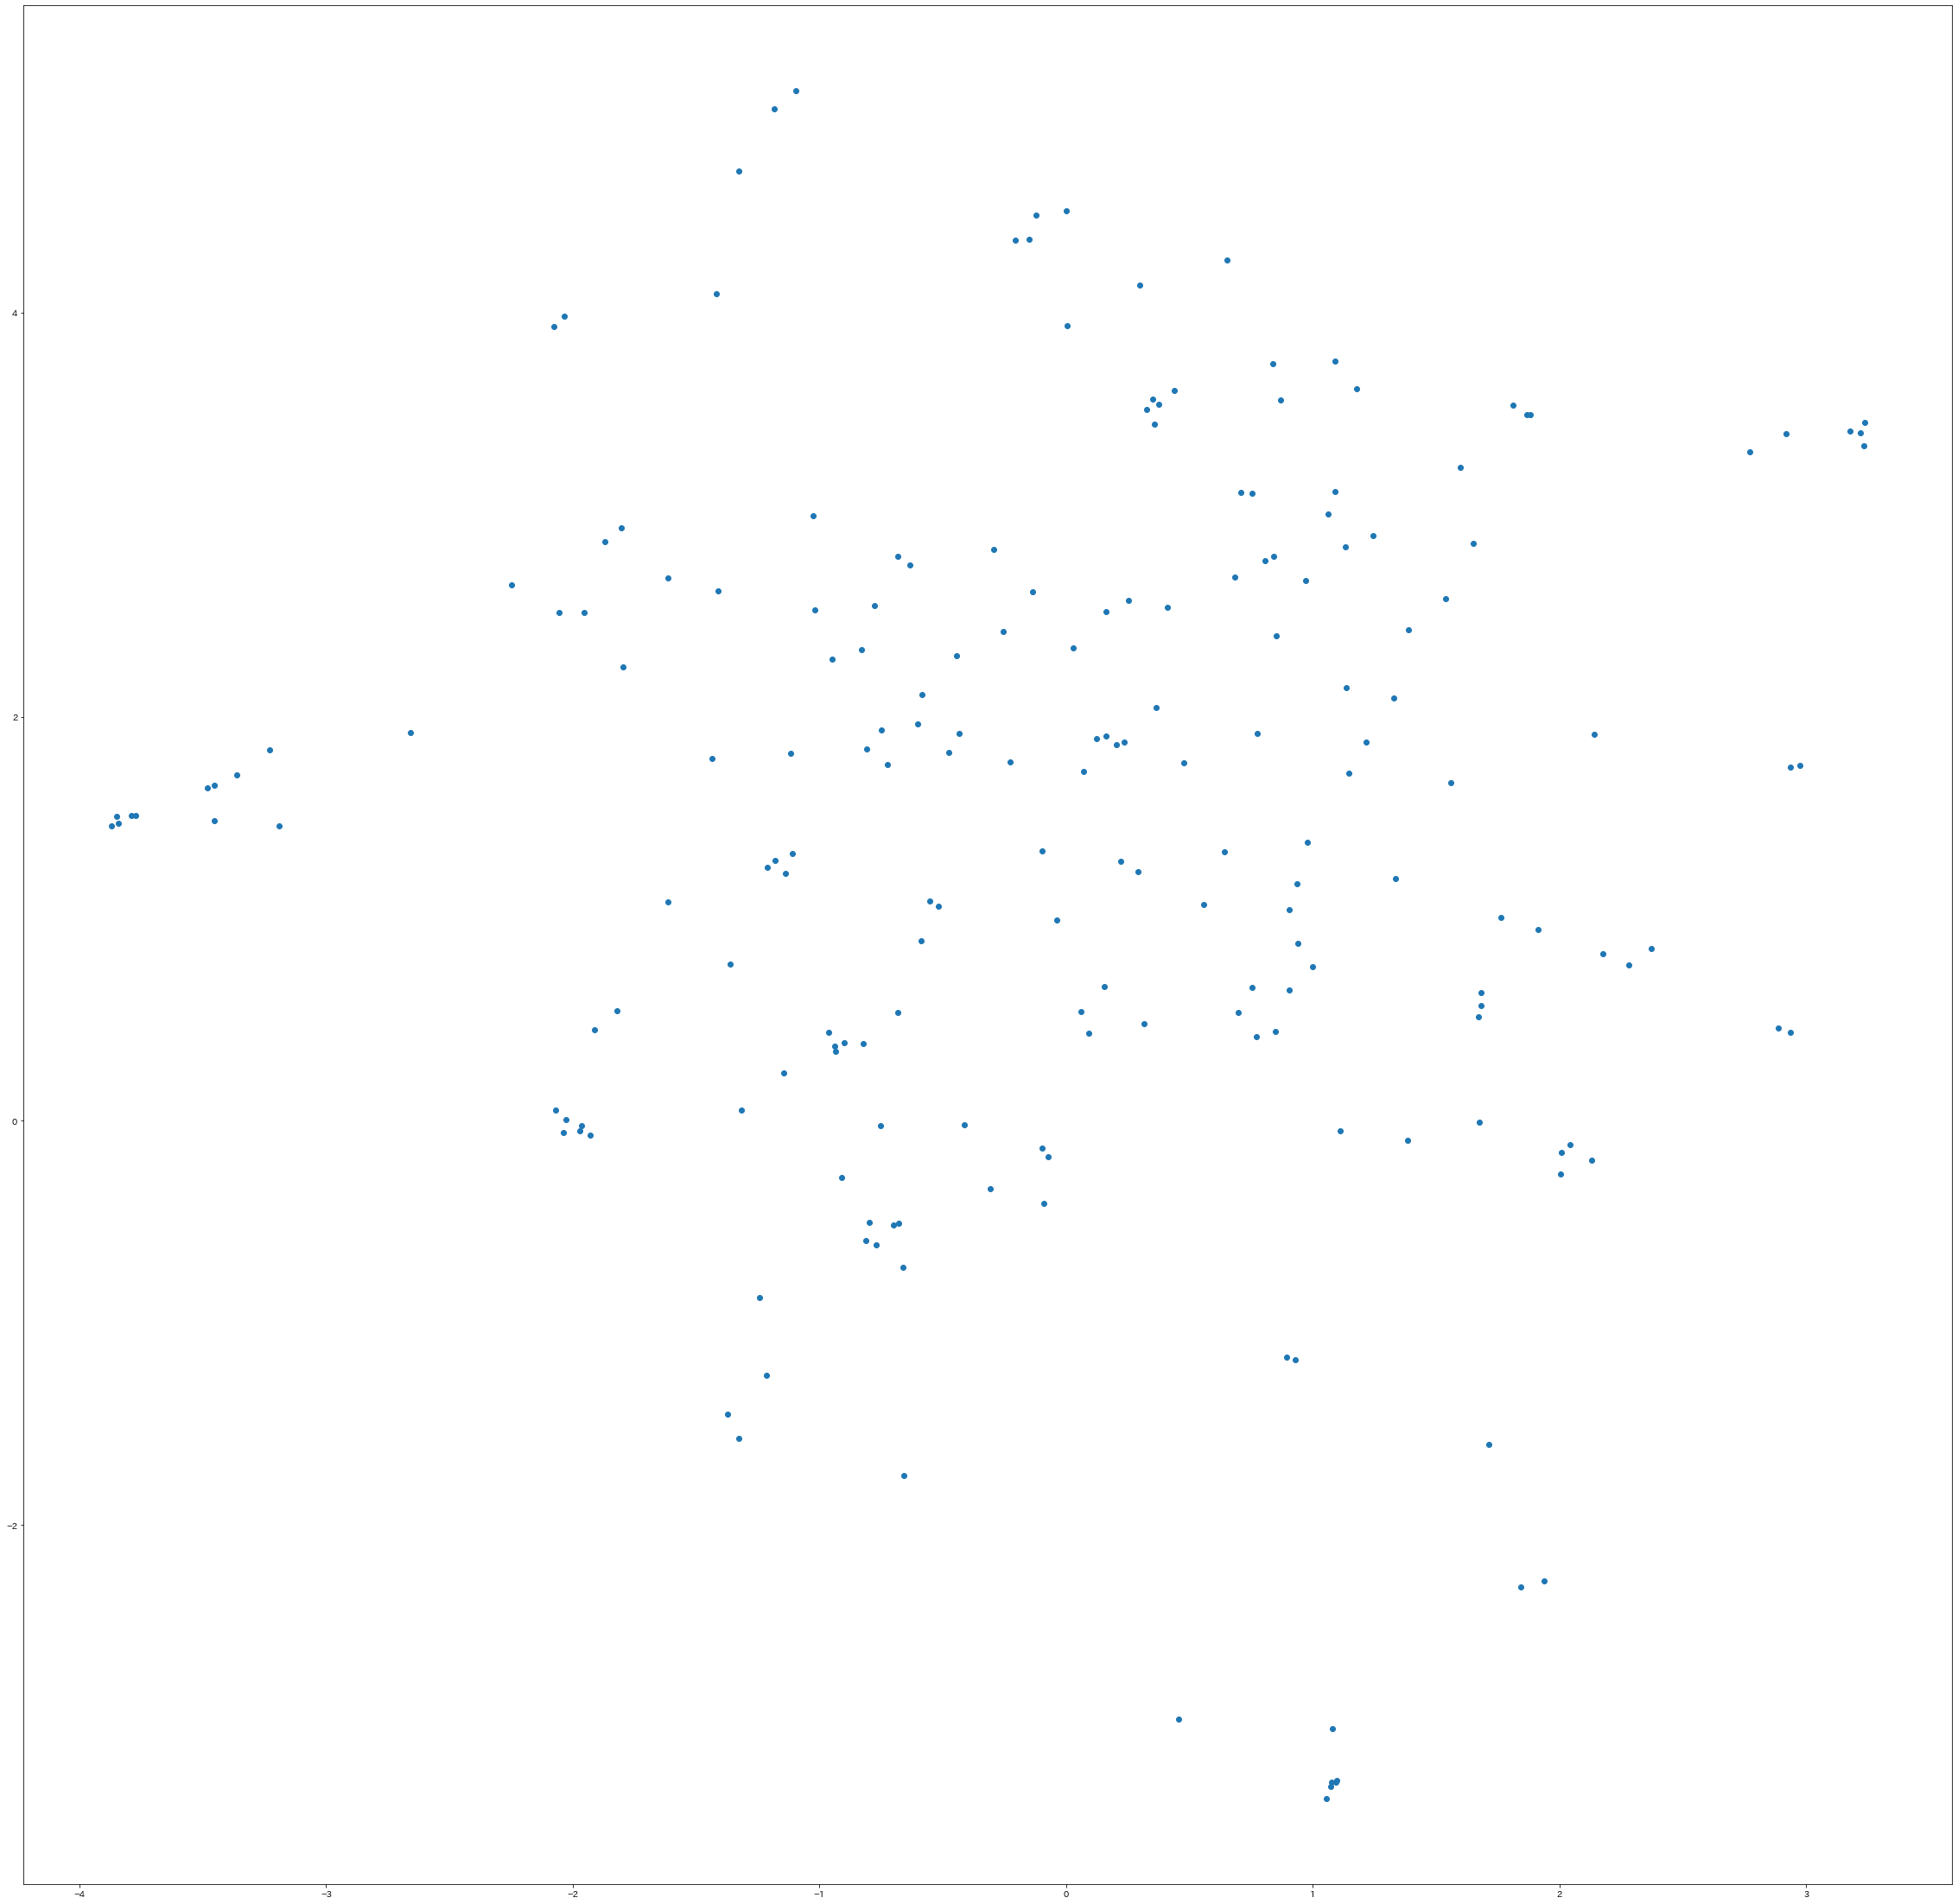

In [21]:
plt.figure(figsize=(40, 40))
n_plot = 200
plt.scatter(emb[:n_plot, 0], emb[:n_plot, 1])

# TODO get label
#for label, x, y in zip(labels[:n_plot], emb[:n_plot, 0], emb[:n_plot, 1]):

    #plt.annotate(item_labels[label], xy=(x, y), size=23
    #             , xytext=(5, 2), textcoords='offset points')
    
plt.show()

In [23]:
# clustering
from sklearn.cluster import KMeans
n_clusters = 10
kmeans_model = KMeans(n_clusters=n_clusters, verbose=0, random_state=42, n_jobs=-1)

tokens = [model[word] for word in model.wv.vocab]
kmeans_model.fit(tokens)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  
/usr/local/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


KMeans(n_clusters=10, n_jobs=-1, random_state=42)

In [34]:
# TODO label
from collections import defaultdict

cluster_labels = kmeans_model.labels_
#cluster_to_words = defaultdict(list)
#for cluster_id, word in zip(cluster_labels, labels):
#    cluster_to_words[cluster_id].append(labels[word])

In [30]:
#df_c = pd.DataFrame()
#for i, words in enumerate(cluster_to_words.values()):
#    df_c = df_c.append(pd.DataFrame({
#        'c_no': [i]*10,
#        'item': words[10:20]
#    }),ignore_index=True)
#    print(words[:10])
    

In [32]:
#df_c.tail(10)

#### word2vec

In [43]:
import numpy as np

# groupbyするよりはやい
#@see https://stackoverflow.com/questions/22219004/grouping-rows-in-list-in-pandas-groupby/42550516#42550516
def group_values_as_list(df, key_col_name='a', val_col_name='b'):
    # a, bの配列
    keys, values = df[[key_col_name, val_col_name]].sort_values(by=[key_col_name]).values.T
    # uniqueの値とそのindex
    ukeys, index = np.unique(keys, return_index=True)
    # bの配列について、index(valuesの長さ)ごとに分割していく
    arrays = np.split(values, index[1:])
    df2 = pd.DataFrame({key_col_name:ukeys
                        , val_col_name:[list(a) for a in arrays]})
    return df2

In [44]:
df.head(1)

,id_from,id_to
0,1,1


In [58]:
df['id_to'] = df['id_to'].astype(str)
df.dtypes

id_from     int64
id_to      object
dtype: object

In [59]:
df_word = group_values_as_list(df, key_col_name='id_from', val_col_name='id_to')


In [60]:
sents = df_word['id_to'].to_list()

In [61]:
sents[0]

['1', '2', '3', '4']

In [62]:
#sents

In [63]:
from gensim.models import word2vec
model = word2vec.Word2Vec(sents,
                          #sg=0,
                          iter=20,
                          size=200,
                          #min_count=1,
                          window=300,
                          #hs=1,
                          negative=0)

In [64]:
len(model.wv.vocab)

66

In [65]:
model.save('./w2v.model')

n2v vs w2v

比較項目

- itemの数

n2v: 24742

w2v: 3227

- いくつかの求人topn


In [66]:
from gensim.models import word2vec

def load_model(filepath='./vectors.bin'):
    model = word2vec.Word2Vec.load(filepath)
    return model

In [67]:
w2v_model = load_model('./w2v.model')
n2v_model = load_model('./n2v.model')


In [69]:
# w2v
w2v_tokens = [w2v_model[word] for word in w2v_model.wv.vocab]
w2v_labels = [word for word in w2v_model.wv.vocab]
#w2v_labels, w2v_labels = get_labels(w2v_labels, df)


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [70]:
len(w2v_labels)

66

In [71]:
# n2v
n2v_tokens = [n2v_model[word] for word in n2v_model.wv.vocab]
n2v_labels = [word for word in n2v_model.wv.vocab]
#n2v_labels, n2v_labels = get_labels(n2v_labels, df)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [72]:
len(n2v_labels)

829

In [73]:
items = []

def get_sim_topn_df(model, items, labels, topn=10):
    sims = []
    for i in items:
        res = model.wv.most_similar(
           positive=[i],
           topn=topn
        )
        #for vocab, sim in res:
        #    print(labels[vocab])
        sims += [[labels[i]]+labels[vocab].split('_')+[sim] for vocab, sim in res]
    #return sims
    df = pd.DataFrame(sims, columns=['target', 'item_id', 'item_name', 'sim'])
    return df


In [75]:
df_w2v = get_sim_topn_df(w2v_model, items, w2v_labels)
df_w2v.shape

In [86]:
df_w2v.to_csv('w2v_recs.csv', index=False)

In [84]:
df_n2v = get_sim_topn_df(n2v_model, items, n2v_labels)
df_n2v.shape

(40, 5)

In [87]:
df_n2v.to_csv('n2v_recs.csv', index=False)